In [104]:
#!pip install xgboost
#!pip install imblearn

In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

## 1. Load & Preview Data

In [106]:
# Load the CSV
df = pd.read_csv("../data/Telco_Customer_Churn_feature_engineered_v1.csv")

# Quick preview
df.head()

,customerID,IsSeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,HasPartnerOrDependents,ExpectedTotalCharges,BillingDiffPct,Churn_num,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureGroup_Early,TenureGroup_Loyal,PackageChangeBehavior_Downgrade,PackageChangeBehavior_Upgrade
0,7590-VHVEG,0,1,29.85,29.85,No,1,29.85,0.000000,0,...,False,False,True,False,True,False,False,False,False,False
1,5575-GNVDE,0,34,56.95,1889.50,No,0,1936.30,-0.024170,0,...,True,False,False,False,False,True,False,True,True,False
2,3668-QPYBK,0,2,53.85,108.15,Yes,0,107.70,0.004178,1,...,False,False,True,False,False,True,False,False,False,False
3,7795-CFOCW,0,45,42.30,1840.75,No,0,1903.50,-0.032965,0,...,True,False,False,False,False,False,False,True,True,False
4,9237-HQITU,0,2,70.70,151.65,Yes,0,141.40,0.072484,1,...,False,False,True,False,True,False,False,False,False,True


In [107]:
X = df.drop(columns=['customerID', 'Churn','Churn_num'])
y = df['Churn_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [108]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [109]:
def precision_recall_curve_draw(precisions = precisions, recalls = recalls, thresholds = thresholds, threshold = threshold):
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
    plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 2a. Basic Model Training (Logistic Regression)

### Simple Logistic Regression no modification

In [110]:
#Restart
#Defining the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000, random_state = 42)

# Grid of hyperparameters 
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1','l2'], 
    'solver': ['saga'],
    'class_weight': ['balanced']
}

# Grid Search with recall as the scoring metric because accuracy is not a good measure in imbalanced datasets and catching churn is the business case
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("🔧 Best Parameters:", grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))


🔧 Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

📊 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.65      0.76      1035
       Churn       0.46      0.81      0.58       374

    accuracy                           0.69      1409
   macro avg       0.68      0.73      0.67      1409
weighted avg       0.79      0.69      0.71      1409



### Logistic Regression changing threshold

📉 Threshold set to: 0.36
              precision    recall  f1-score   support

    No Churn       0.91      0.70      0.79      4139
       Churn       0.49      0.81      0.61      1495

    accuracy                           0.73      5634
   macro avg       0.70      0.75      0.70      5634
weighted avg       0.80      0.73      0.74      5634



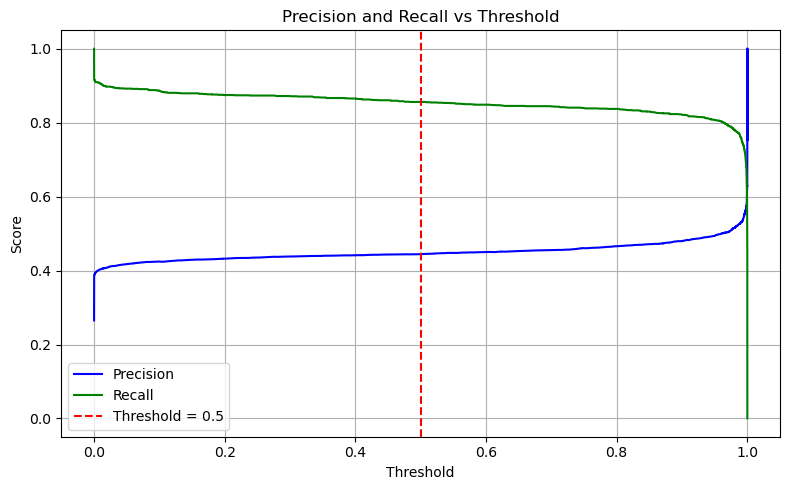

In [134]:
# Changing threshold based on training
# 1. Get predicted probabilities for the positive class (Churn = 1)
y_probs = best_model.predict_proba(X_train)[:, 1]

# 2. Set custom threshold
threshold = 0.36  #After reading the graph
y_pred_threshold = (y_probs >= threshold).astype(int)

# 3. Evaluate performance
print(f"📉 Threshold set to: {threshold}")
print(classification_report(y_train, y_pred_threshold, target_names=["No Churn", "Churn"]))

# 4. (Optional) Plot Precision-Recall vs. Threshold curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_probs)

precision_recall_curve_draw()

In [112]:
# Evaluate the threshold change on the test data
# 1. Get predicted probabilities for the positive class (Churn = 1)
y_probs = best_model.predict_proba(X_test)[:, 1]

# 2. Set custom threshold
threshold = 0.36  #After reading the graph
y_pred_threshold = (y_probs >= threshold).astype(int)

# 3. Evaluate performance
print(f"📉 Threshold set to: {threshold}")
print(classification_report(y_test, y_pred_threshold, target_names=["No Churn", "Churn"]))


📉 Threshold set to: 0.36
              precision    recall  f1-score   support

    No Churn       0.94      0.51      0.66      1035
       Churn       0.40      0.91      0.56       374

    accuracy                           0.62      1409
   macro avg       0.67      0.71      0.61      1409
weighted avg       0.80      0.62      0.63      1409



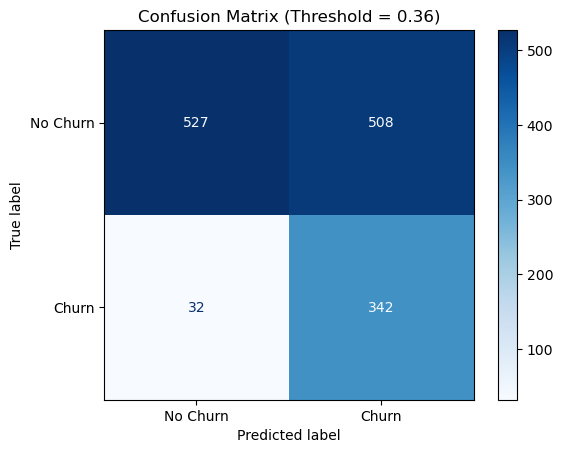

In [113]:
#Create new confusion matrix
y_pred_thresh = (y_probs >= 0.36).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])

disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Threshold = 0.36)")
plt.grid(False)
plt.show()


### Apply SMOTE to try to handle the imbalance

In [114]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Define hyperparameter grid
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1','l2'],
    'clf__solver': ['saga'],
    'clf__class_weight': [None]
}

# Run grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on original (not SMOTE-resampled) training data
grid_search.fit(X_train, y_train)

# Get best model and predict
best_model = grid_search.best_estimator_
y_probs_sm = best_model.predict_proba(X_test)[:, 1]


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [115]:
y_pred_sm = (y_probs_sm >= 0.5).astype(int)

In [116]:
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_sm, target_names=["No Churn", "Churn"]))


📊 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.86      0.80      0.83      1035
       Churn       0.54      0.66      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.76      0.77      1409



## 📌 Conclusion on Logistic Regression

The Logistic Regression model demonstrated strong performance in identifying churned customers. After extensive hyperparameter tuning and class balancing techniques, including SMOTE, the model achieved a recall of 80% on the churn class. However, this came at the cost of precision, resulting in an overall accuracy of 46% on the churn predictions.

While SMOTE did not yield further improvements in recall compared to class weighting and threshold adjustment alone, it confirmed the model’s robustness across different balancing strategies.

## 2b. Basic Model Training (Decision Tree)

### Simple Decision Tree with grid search

In [117]:
#Defining the tree model
tree = DecisionTreeClassifier(random_state=42)

# Grid of hyperparameters 
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'class_weight': [None, 'balanced']
}

# Grid Search with recall as the scoring metric because accuracy is not a good measure in imbalanced datasets and catching churn is the business case
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_tree = grid_search.best_estimator_
y_pred_tree = best_tree.predict(X_test)

print("🔧 Best Parameters:", grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_tree, target_names=["No Churn", "Churn"]))


🔧 Best Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}

📊 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.91      0.69      0.79      1035
       Churn       0.49      0.81      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.74      1409



### Decision Tree changing threshold

📉 Threshold set to: 0.38
              precision    recall  f1-score   support

    No Churn       0.93      0.66      0.77      4139
       Churn       0.48      0.87      0.62      1495

    accuracy                           0.71      5634
   macro avg       0.71      0.76      0.69      5634
weighted avg       0.81      0.71      0.73      5634



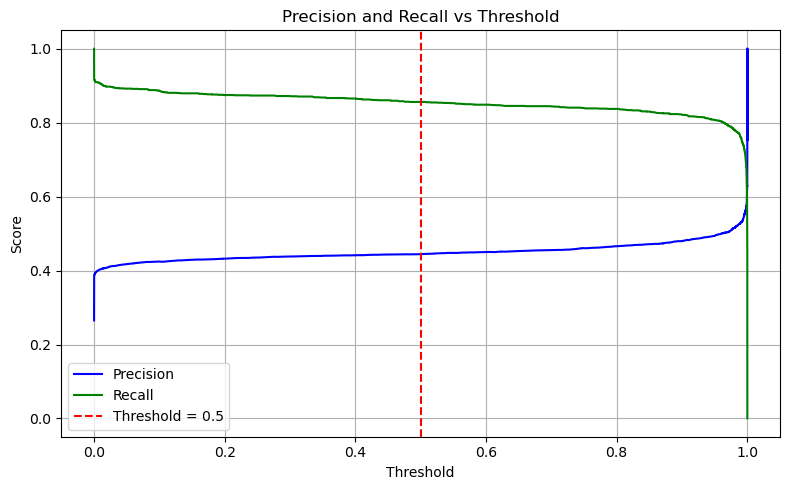

In [118]:
# Changing threshold based on training
# 1. Get predicted probabilities for the positive class (Churn = 1)
y_probs = best_tree.predict_proba(X_train)[:, 1]

# 2. Set custom threshold
threshold = 0.38 
y_pred_threshold = (y_probs >= threshold).astype(int)

# 3. Evaluate performance
print(f"📉 Threshold set to: {threshold}")
print(classification_report(y_train, y_pred_threshold, target_names=["No Churn", "Churn"]))

# 4. (Optional) Plot Precision-Recall vs. Threshold curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_probs)

precision_recall_curve_draw()

In [119]:
# Evaluate the threshold change on the test data
# 1. Get predicted probabilities for the positive class (Churn = 1)
y_probs = best_tree.predict_proba(X_test)[:, 1]

# 2. Set custom threshold
threshold = 0.38  #After reading the graph
y_pred_threshold = (y_probs >= threshold).astype(int)

# 3. Evaluate performance
print(f"📉 Threshold set to: {threshold}")
print(classification_report(y_test, y_pred_threshold, target_names=["No Churn", "Churn"]))

📉 Threshold set to: 0.38
              precision    recall  f1-score   support

    No Churn       0.93      0.66      0.77      1035
       Churn       0.47      0.85      0.61       374

    accuracy                           0.71      1409
   macro avg       0.70      0.75      0.69      1409
weighted avg       0.80      0.71      0.73      1409



### Decision Tree SMOTE

In [120]:
tree_sm = DecisionTreeClassifier(random_state=42)

# Grid of hyperparameters 
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'class_weight': [None]
}

# Grid Search with recall as the scoring metric because accuracy is not a good measure in imbalanced datasets and catching churn is the business case
grid_search = GridSearchCV(
    estimator=tree_sm,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)
grid_search.fit(X_train_sm, y_train_sm)

# Best model evaluation
best_tree_sm = grid_search.best_estimator_
y_pred_tree_sm = best_tree_sm.predict(X_test)

print("🔧 Best Parameters:", grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_tree_sm, target_names=["No Churn", "Churn"]))

🔧 Best Parameters: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

📊 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.80      0.82      1035
       Churn       0.52      0.61      0.56       374

    accuracy                           0.75      1409
   macro avg       0.68      0.70      0.69      1409
weighted avg       0.76      0.75      0.75      1409



📉 Threshold set to: 0.5


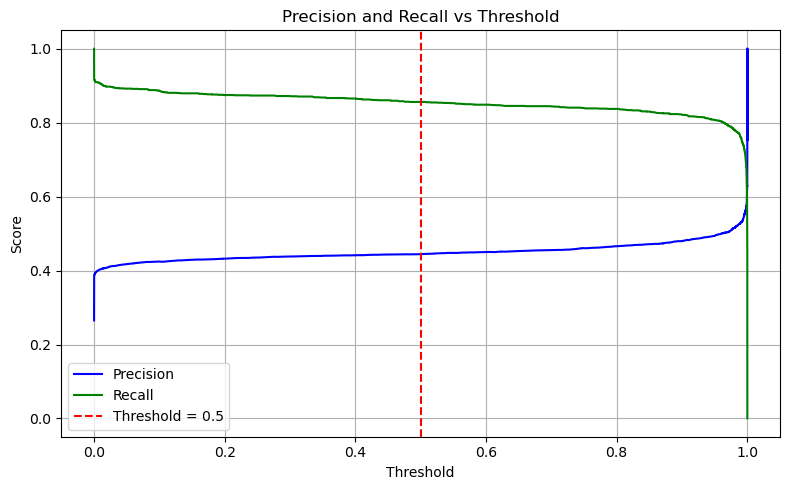

In [121]:
y_probs_sm = best_tree_sm.predict_proba(X_train_sm)[:, 1]
# 2. Set custom threshold
threshold = 0.5
y_pred_thresh_sm = (y_probs_sm >= threshold).astype(int)

# 3. Evaluate performance
print(f"📉 Threshold set to: {threshold}")

# 4. (Optional) Plot Precision-Recall vs. Threshold curve
precisions, recalls, thresholds = precision_recall_curve(y_train_sm, y_probs_sm)

precision_recall_curve_draw()

In [122]:
# 3. Predict on original test set
y_probs_sm = best_tree_sm.predict_proba(X_test)[:, 1]

# 4. Apply custom threshold
threshold = 0.3
y_pred_thresh_sm = (y_probs_sm >= threshold).astype(int)

# 5. Evaluate
print(f"📉 Threshold set to: {threshold}")
print(classification_report(y_test, y_pred_thresh_sm, target_names=["No Churn", "Churn"]))

📉 Threshold set to: 0.3
              precision    recall  f1-score   support

    No Churn       0.89      0.67      0.76      1035
       Churn       0.45      0.77      0.57       374

    accuracy                           0.69      1409
   macro avg       0.67      0.72      0.67      1409
weighted avg       0.77      0.69      0.71      1409



## 📌 Conclusion on Decision Tree

The Decision Tree model demonstrated strong performance in identifying churned customers. After extensive hyperparameter tuning and class balancing techniques, including SMOTE, the model achieved a recall of 85% on the churn class. However, this came at the cost of precision, resulting in an overall accuracy of 47% on the churn predictions.

While SMOTE did not yield further improvements in recall compared to class weighting and threshold adjustment alone, it confirmed the model’s robustness across different balancing strategies.

## 2c. Basic Model Training (Random Forest)

### Simple Random Forest with grid search

In [123]:
'''
#Defining the tree model
forest = RandomForestClassifier(random_state=42)

# Grid of hyperparameters 

param_grid = {
    'n_estimators': [100, 200, 500],              # Number of trees
    'max_depth': [10, 20, 30],                    # Limit tree depth to prevent overfitting
    'min_samples_split': [2, 5, 10],              # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],                # Minimum samples at a leaf node
    'max_features': ['sqrt', 'log2', None],       # Features to consider for best split
    'class_weight': [None, 'balanced'],           # To deal with imbalance (optional if using SMOTE)
    'bootstrap': [True, False]                    # Whether to use bootstrap samples
}

# Grid Search with recall as the scoring metric because accuracy is not a good measure in imbalanced datasets and catching churn is the business case
grid_search = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_forest = grid_search.best_estimator_
y_pred_forest = best_forest.predict(X_test)

print("🔧 Best Parameters:", grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_forest, target_names=["No Churn", "Churn"]))
'''

'\n#Defining the tree model\nforest = RandomForestClassifier(random_state=42)\n\n# Grid of hyperparameters \n\nparam_grid = {\n    \'n_estimators\': [100, 200, 500],              # Number of trees\n    \'max_depth\': [10, 20, 30],                    # Limit tree depth to prevent overfitting\n    \'min_samples_split\': [2, 5, 10],              # Minimum samples to split an internal node\n    \'min_samples_leaf\': [1, 2, 4],                # Minimum samples at a leaf node\n    \'max_features\': [\'sqrt\', \'log2\', None],       # Features to consider for best split\n    \'class_weight\': [None, \'balanced\'],           # To deal with imbalance (optional if using SMOTE)\n    \'bootstrap\': [True, False]                    # Whether to use bootstrap samples\n}\n\n# Grid Search with recall as the scoring metric because accuracy is not a good measure in imbalanced datasets and catching churn is the business case\ngrid_search = GridSearchCV(\n    estimator=forest,\n    param_grid=param_grid,\

🔧 Best Parameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

In [124]:
forest = RandomForestClassifier(bootstrap= False, class_weight= 'balanced', max_depth= 10, max_features= 'log2', min_samples_leaf= 4, min_samples_split= 10, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, random_state=42)

In [125]:
y_pred_forest = forest.predict(X_test)

print("🔧 Best Parameters:", grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_forest, target_names=["No Churn", "Churn"]))

🔧 Best Parameters: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

📊 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.76      0.83      1035
       Churn       0.54      0.77      0.64       374

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409



### Simple Random Forest changing threshold

📉 Threshold set to: 0.4
              precision    recall  f1-score   support

    No Churn       0.99      0.74      0.84      4139
       Churn       0.57      0.98      0.72      1495

    accuracy                           0.80      5634
   macro avg       0.78      0.86      0.78      5634
weighted avg       0.88      0.80      0.81      5634



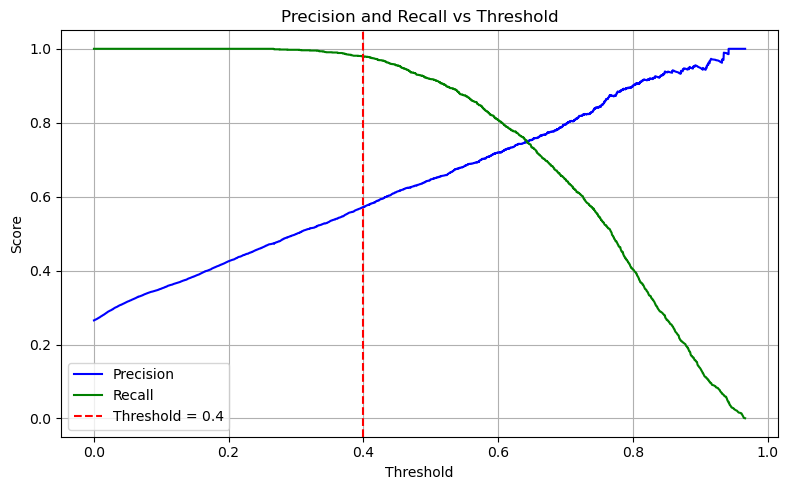

In [126]:
# 1. Get predicted probabilities for the positive class (Churn = 1)
y_probs = forest.predict_proba(X_train)[:, 1]

# 2. Set custom threshold
threshold = 0.4 
y_pred_threshold = (y_probs >= threshold).astype(int)

# 3. Evaluate performance
print(f"📉 Threshold set to: {threshold}")
print(classification_report(y_train, y_pred_threshold, target_names=["No Churn", "Churn"]))

# 4. (Optional) Plot Precision-Recall vs. Threshold curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [127]:
# Evaluate the threshold change on the test data
# 1. Get predicted probabilities for the positive class (Churn = 1)
y_probs = forest.predict_proba(X_test)[:, 1]

# 2. Set custom threshold
threshold = 0.4 #After reading the graph
y_pred_threshold = (y_probs >= threshold).astype(int)

# 3. Evaluate performance
print(f"📉 Threshold set to: {threshold}")
print(classification_report(y_test, y_pred_threshold, target_names=["No Churn", "Churn"]))

📉 Threshold set to: 0.4
              precision    recall  f1-score   support

    No Churn       0.93      0.68      0.78      1035
       Churn       0.49      0.85      0.62       374

    accuracy                           0.72      1409
   macro avg       0.71      0.76      0.70      1409
weighted avg       0.81      0.72      0.74      1409



### Simple Random Forest SMOTE (missing)

## 📌 Conclusion on Random Forest

The Random Forest model demonstrated very similar performance to decision tree with 85% recall and 49% precision

 ## 3a. Advanced Models (Naive Bayes)

### Simple Naive Bayes

In [128]:
# Initialize the model
nb = GaussianNB(var_smoothing=1e-9)

# Fit to training data
nb.fit(X_train, y_train)

# Predict
y_pred = nb.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))

              precision    recall  f1-score   support

    No Churn       0.92      0.61      0.73      1035
       Churn       0.44      0.85      0.58       374

    accuracy                           0.67      1409
   macro avg       0.68      0.73      0.66      1409
weighted avg       0.79      0.67      0.69      1409



📉 Threshold set to: 0.5
              precision    recall  f1-score   support

    No Churn       0.92      0.61      0.74      4139
       Churn       0.44      0.86      0.59      1495

    accuracy                           0.68      5634
   macro avg       0.68      0.73      0.66      5634
weighted avg       0.80      0.68      0.70      5634



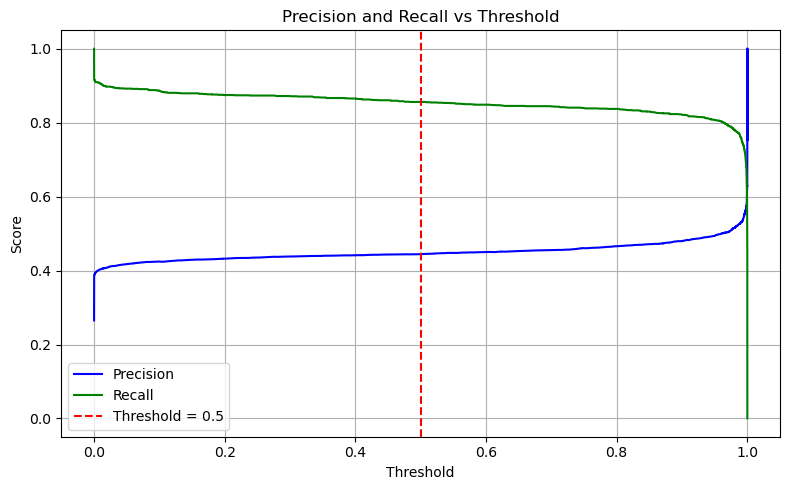

In [129]:
# Changing threshold based on training
# 1. Get predicted probabilities for the positive class (Churn = 1)
y_probs = nb.predict_proba(X_train)[:, 1]

# 2. Set custom threshold
threshold = 0.5 
y_pred_threshold = (y_probs >= threshold).astype(int)

# 3. Evaluate performance
print(f"📉 Threshold set to: {threshold}")
print(classification_report(y_train, y_pred_threshold, target_names=["No Churn", "Churn"]))

# 4. (Optional) Plot Precision-Recall vs. Threshold curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_probs)

precision_recall_curve_draw()

## 📌 Conclusion on Naive Bayes

The Naive Bayes model works suprisingly well with 85% recall and 44% precision

## 3. Advanced Models (XGBoost)

In [130]:
# Logistic Regression Evaluation:
def model_evalulation_metrics(y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [131]:
# GenAI scaffolding
xgb_model = xgb.XGBClassifier(
    n_estimators=100,      # number of trees
    learning_rate=0.1,     # step size shrinkage
    max_depth=5,           # max depth of a tree
    subsample=0.8,         # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42
)

# Fit model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate

print("XGBoost Metrics:")
model_evalulation_metrics(y_pred = y_pred_xgb)

XGBoost Metrics:
Accuracy: 0.7970
Precision: 0.6447
Recall: 0.5241
F1 Score: 0.5782

Confusion Matrix:
 [[927 108]
 [178 196]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.64      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [132]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= 0.3).astype(int)  # changing the threshold to 30% because the cost of churn is much higher than the cost of a false alarm

In [133]:
print("XGBoost Metrics 30% threshold:")
model_evalulation_metrics(y_pred = y_pred_thresh)

XGBoost Metrics 30% threshold:
Accuracy: 0.7686
Precision: 0.5465
Recall: 0.7540
F1 Score: 0.6337

Confusion Matrix:
 [[801 234]
 [ 92 282]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      1035
           1       0.55      0.75      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409

